In [1]:
import os
import re
import sys
import gzip
import json
import codecs
import pyBigWig
import numpy as np
from pyfaidx import Fasta
from scipy.stats import spearmanr, pearsonr, gaussian_kde
from matplotlib import pyplot as plt
from scipy.stats import percentileofscore
%matplotlib inline

In [2]:
!head data/experimental/GR_bindingcurves_WT_1_out.csv

Oligo,Kd_estimate,ddG,Motif,Sequence
1,2821.6235278513755,0.3425088971961442,GR_ChIP,CGCAATTGCGAGTCCAGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
2,5008.443828838408,0.6788923505136192,GR_ChIP_Mut-1A,CGCAATTGCGAGTCAAGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
3,3987.3585357644347,0.5452352269348365,GR_ChIP_Mut-1G,CGCAATTGCGAGTCGAGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
4,3733.826608343778,0.5067229473040138,GR_ChIP_Mut-1T,CGCAATTGCGAGTCTAGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
5,3089.9123931511535,0.39575589567558056,GR_ChIP_Mut0C,CGCAATTGCGAGTCCCGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
6,3442.6173547018757,0.45912055357522213,GR_ChIP_Mut0G,CGCAATTGCGAGTCCGGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
7,3771.5460947292295,0.512615338071704,GR_ChIP_Mut0T,CGCAATTGCGAGTCCTGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
8,9751.071602371612,1.0694659312826293,GR_ChIP_Mut1A,CGCAATTGCGAGTCCAAAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
9,11216.508695911303,1.1515430072503294,GR_ChIP_Mut1C,CGCAATTGCGAGTCCACAACATTCTG

In [3]:
!head data/experimental/GR_bindingcurves_WT_2_out.csv

Oligo,Kd_estimate,ddG,Motif,Sequence
1,3776.303577465563,0.30024879617973826,GR_ChIP,CGCAATTGCGAGTCCAGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
2,4349.065417626428,0.38303276403239817,GR_ChIP_Mut-1A,CGCAATTGCGAGTCAAGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
3,4806.641303794279,0.44167730706356645,GR_ChIP_Mut-1G,CGCAATTGCGAGTCGAGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
4,3585.415277489782,0.26984051856650243,GR_ChIP_Mut-1T,CGCAATTGCGAGTCTAGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
5,3934.632204183049,0.32432609596226325,GR_ChIP_Mut0C,CGCAATTGCGAGTCCCGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
6,3078.640367627234,0.18050788298518797,GR_ChIP_Mut0G,CGCAATTGCGAGTCCGGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
7,5389.839393586962,0.5088100546804325,GR_ChIP_Mut0T,CGCAATTGCGAGTCCTGAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
8,11672.210661617783,0.9617833885026131,GR_ChIP_Mut1A,CGCAATTGCGAGTCCAAAACATTCTGTTCCTCGACCTTCCTCTCCGGCGGTATGAC
9,19521.322732397042,1.2632768756094361,GR_ChIP_Mut1C,CGCAATTGCGAGTCCACAACATTCT

In [4]:
!tail data/experimental/GR_bindingcurves_WT_1_out.csv

181,488949.7394676223,3.364468176368103,MSX2_GRE2.4,CGCAATTGCGAGTCCCTAGATCTGCACGGTTCGACCTTCCTCTCCGGCGGTATGAC
182,55131.017431937646,2.085004300320746,WNT5A_GRE2.1,CGCAATTGCGAGTCCGGAACACTGAGTGATTCGACCTTCCTCTCCGGCGGTATGAC
183,143944.13366659632,2.647611981979618,WNT5A_GRE2.2,CGCAATTGCGAGTCCAGAGCTTCGTGTACTTCGACCTTCCTCTCCGGCGGTATGAC
184,22810.13419893419,1.5676562465803805,ZNF189_GRE1.1,CGCAATTGCGAGTCCtgtactttccgtcctTCGACCTTCCTCTCCGGCGGTATGAC
185,16122.502946294013,1.364242642526455,ZNF189_GRE1.2,CGCAATTGCGAGTCCttcacataatgttccTCGACCTTCCTCTCCGGCGGTATGAC
186,483021.6801978665,3.357317307662853,ZNF189_GRE1.3,CGCAATTGCGAGTCCggaaaactaatgcttTCGACCTTCCTCTCCGGCGGTATGAC
187,39916.96701045571,1.8957057701170397,SDPR_GRE1AB,CGCAATTGCGAGTCCAGGACACTTTGTTGCTCGACCTTCCTCTCCGGCGGTATGAC
188,237639.39974132643,2.94150368459264,KIF25_GRE3,CGCAATTGCGAGTCCCCATGCTATTTAGAATCGACCTTCCTCTCCGGCGGTATGAC
189,1014375.3348347225,3.7922767994755544,IGFB1_GRE1.1,CGCAATTGCGAGTCCCATACACATCAAACATCGACCTTCCTCTCCGGCGGTATGAC
190,

In [5]:
!tail data/experimental/GR_bindingcurves_WT_2_out.csv

181,819741.1178488896,3.454282046579126,MSX2_GRE2.4,CGCAATTGCGAGTCCCTAGATCTGCACGGTTCGACCTTCCTCTCCGGCGGTATGAC
182,118410.94462628893,2.3200377196505695,WNT5A_GRE2.1,CGCAATTGCGAGTCCGGAACACTGAGTGATTCGACCTTCCTCTCCGGCGGTATGAC
183,181153.77179450102,2.5692918710667594,WNT5A_GRE2.2,CGCAATTGCGAGTCCAGAGCTTCGTGTACTTCGACCTTCCTCTCCGGCGGTATGAC
184,29564.748528925422,1.506604467107507,ZNF189_GRE1.1,CGCAATTGCGAGTCCtgtactttccgtcctTCGACCTTCCTCTCCGGCGGTATGAC
185,28182.61033197168,1.4785374235338185,ZNF189_GRE1.2,CGCAATTGCGAGTCCttcacataatgttccTCGACCTTCCTCTCCGGCGGTATGAC
186,597455.9717704367,3.2688543774097623,ZNF189_GRE1.3,CGCAATTGCGAGTCCggaaaactaatgcttTCGACCTTCCTCTCCGGCGGTATGAC
187,67464.48867999925,1.9902510718282262,SDPR_GRE1AB,CGCAATTGCGAGTCCAGGACACTTTGTTGCTCGACCTTCCTCTCCGGCGGTATGAC
188,307282.375640026,2.879065432263495,KIF25_GRE3,CGCAATTGCGAGTCCCCATGCTATTTAGAATCGACCTTCCTCTCCGGCGGTATGAC
189,703251.2976860375,3.364428817691273,IGFB1_GRE1.1,CGCAATTGCGAGTCCCATACACATCAAACATCGACCTTCCTCTCCGGCGGTATGAC
190,

adapters

In [6]:
seqToDdg = {}
firstLine = True
with open("data/experimental/GR_bindingcurves_WT_1_out.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        Oligo,Kd_estimate,ddG,Motif,Sequence = line.strip().split(',')
        seq = Sequence.upper()[14:30]
        if seq not in seqToDdg:
            seqToDdg[seq] = []
        seqToDdg[seq].append(float(ddG))

In [7]:
firstLine = True
with open("data/experimental/GR_bindingcurves_WT_2_out.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        Oligo,Kd_estimate,ddG,Motif,Sequence = line.strip().split(',')
        seq = Sequence.upper()[14:30]
        seqToDdg[seq].append(float(ddG))

In [8]:
tfToBigWigs = {}
tfToBigWigs["exo"] = (pyBigWig.open("data/k5/k5.pos.bigwig"),
                           pyBigWig.open("data/k5/k5.neg.bigwig"))
tfToBigWigs["exoNoCtl"] = (pyBigWig.open("data/noCtlK5/noCtlK5.pos.bigwig"),
                           pyBigWig.open("data/noCtlK5/noCtlK5.neg.bigwig"))
tfToBigWigs["seq_bjr"] = (pyBigWig.open("data/a5/seq_bjr/pos.bigwig"),
                           pyBigWig.open("data/a5/seq_bjr/neg.bigwig"))

In [9]:
fastapath = "data/genome/male.hg19.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [10]:
chrms = list(GenomeDict.keys())

In [11]:
seqToCoord = {}
for chrm in chrms:
    if "_" in chrm: continue
    sequence = GenomeDict[chrm].upper()
    for motif in seqToDdg.keys():
        for m in re.finditer(motif, sequence):
            if motif not in seqToCoord:
                seqToCoord[motif] = []
            seqToCoord[motif].append((chrm, m.start()))

In [12]:
len(seqToCoord.keys())

74

In [13]:
seq_len = 1200
posFootprint = {}
negFootprint = {}
for key in tfToBigWigs.keys():
    posFootprint[key] = {}
    negFootprint[key] = {}
    for motif in seqToCoord.keys():
        currentPosCounts= []
        currentNegCounts = []
        for chrm, motif_start in seqToCoord[motif]: 
            if "_" in chrm: continue
            center = motif_start+8
            start = int(center-(seq_len/2))
            end = int(center+(seq_len/2))
            posvals = np.array(tfToBigWigs[key][0].values(chrm, start, end))
            where_are_NaNs = np.isnan(posvals)
            posvals[where_are_NaNs] = 0.0
            currentPosCounts.append(posvals)
            negvals = np.array(tfToBigWigs[key][1].values(chrm, start, end))
            where_are_NaNs = np.isnan(negvals)
            negvals[where_are_NaNs] = 0.0
            currentNegCounts.append(negvals)
        posFootprint[key][motif] = np.mean(np.array(currentPosCounts), axis = 0)
        negFootprint[key][motif] = np.mean(np.array(currentNegCounts), axis = 0)

In [14]:
xvals = []
for motif in seqToCoord.keys():
    xvals.append(np.mean(seqToDdg[motif]))

Window Size:  16
exo


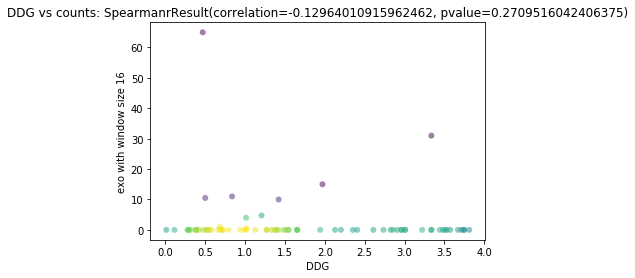

exoNoCtl


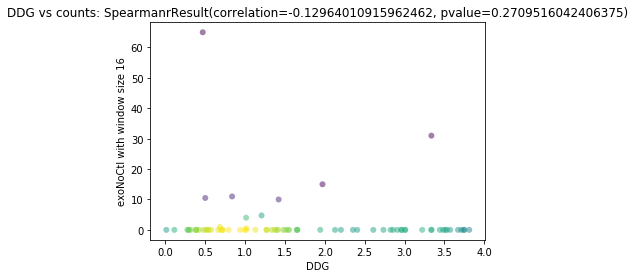

seq_bjr


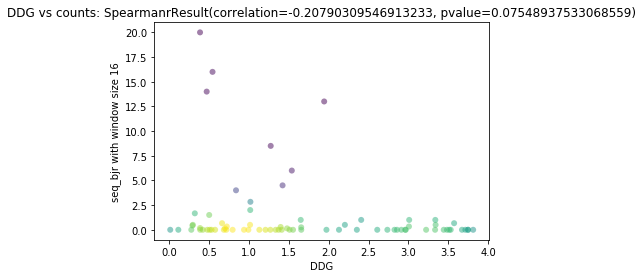

Window Size:  32
exo


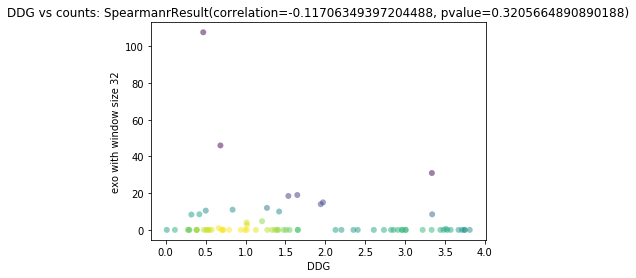

exoNoCtl


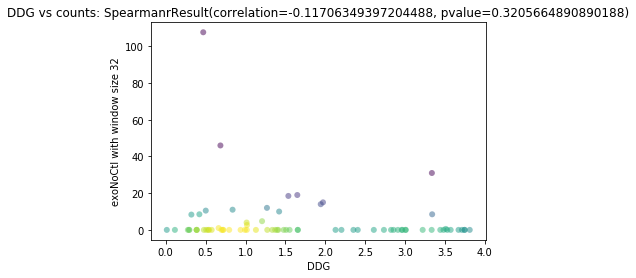

seq_bjr


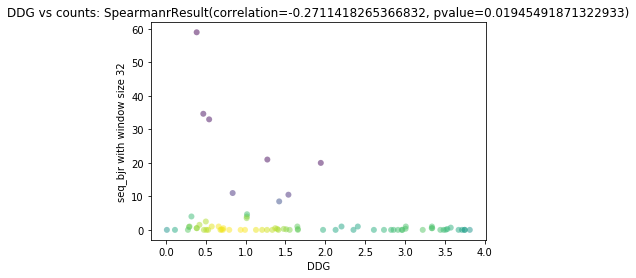

Window Size:  64
exo


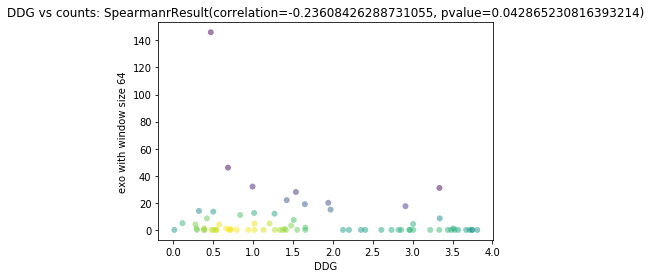

exoNoCtl


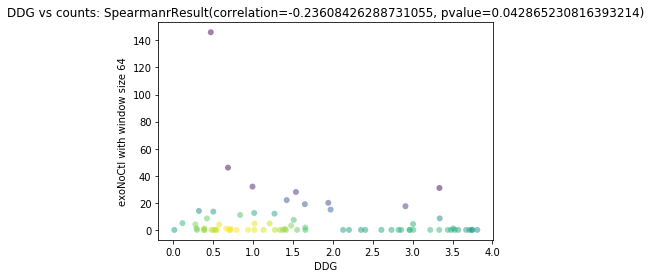

seq_bjr


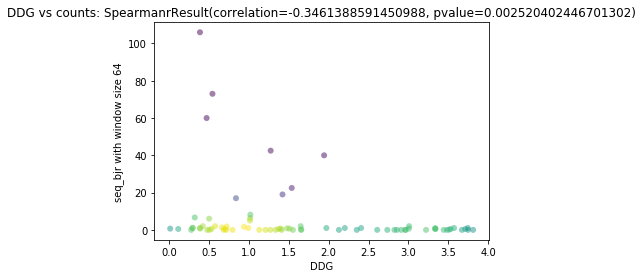

Window Size:  128
exo


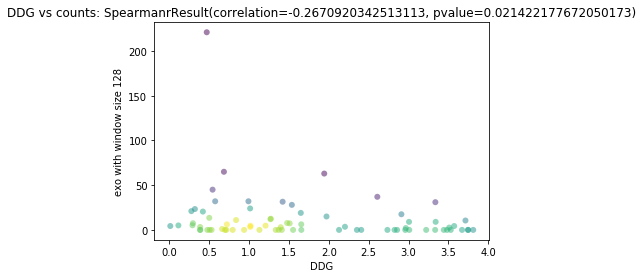

exoNoCtl


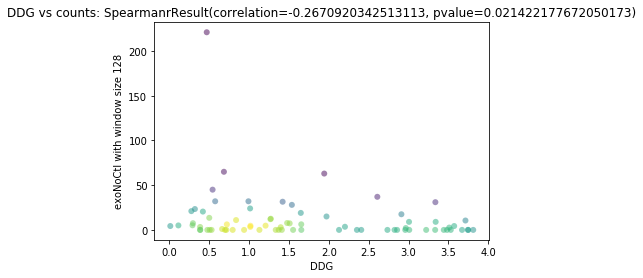

seq_bjr


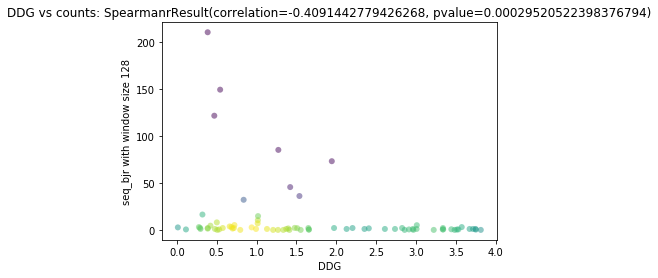

Window Size:  150
exo


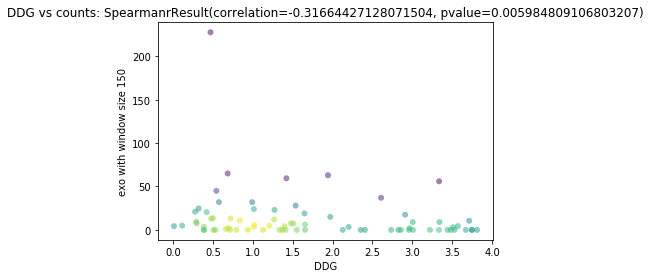

exoNoCtl


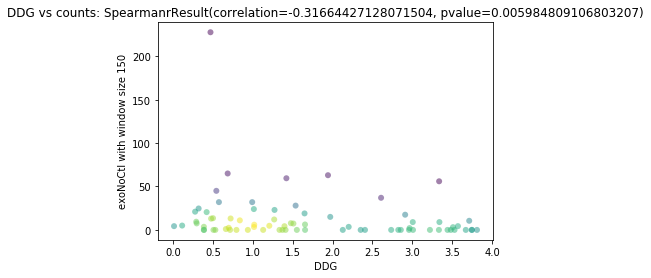

seq_bjr


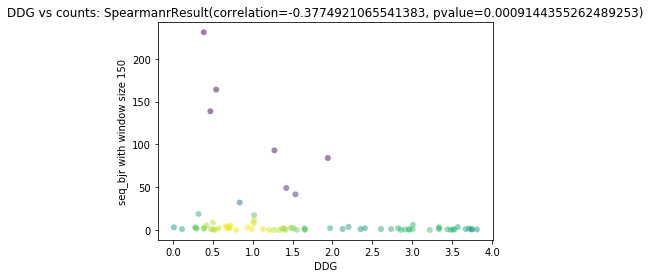

Window Size:  200
exo


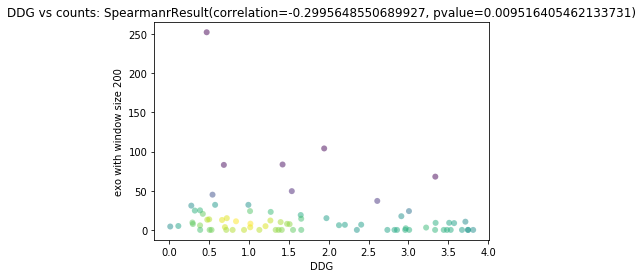

exoNoCtl


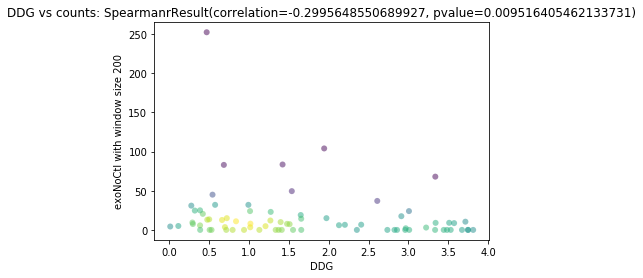

seq_bjr


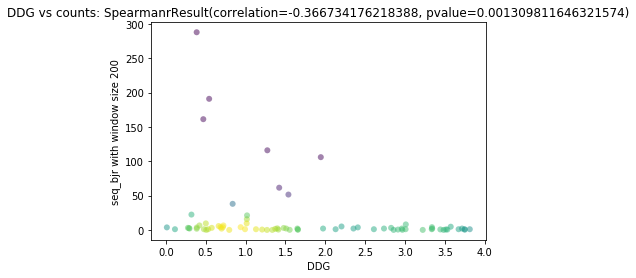

Window Size:  256
exo


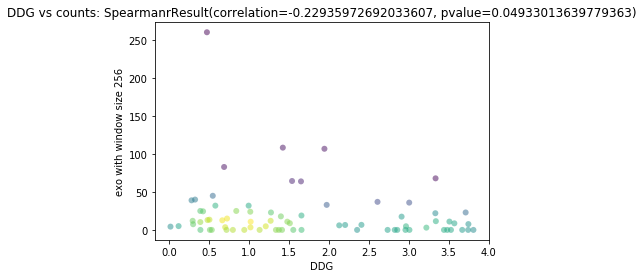

exoNoCtl


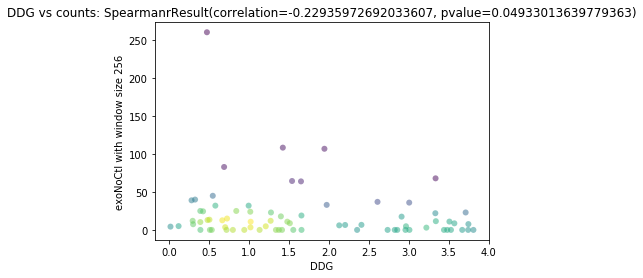

seq_bjr


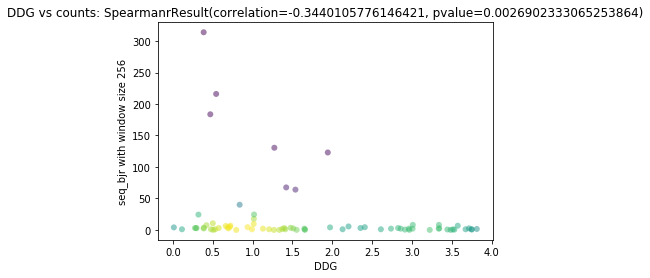

Window Size:  546
exo


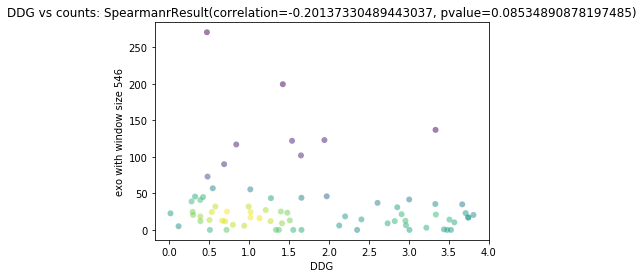

exoNoCtl


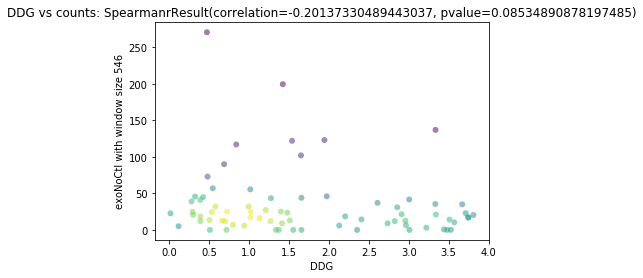

seq_bjr


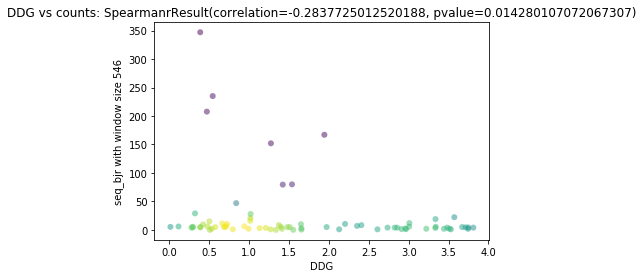

Window Size:  1000
exo


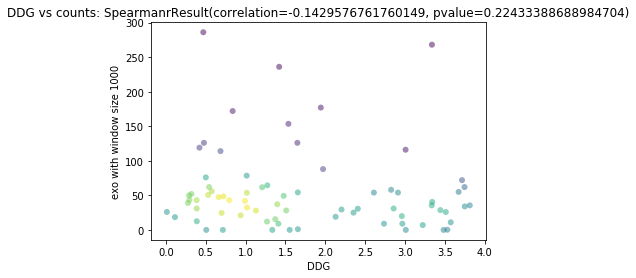

exoNoCtl


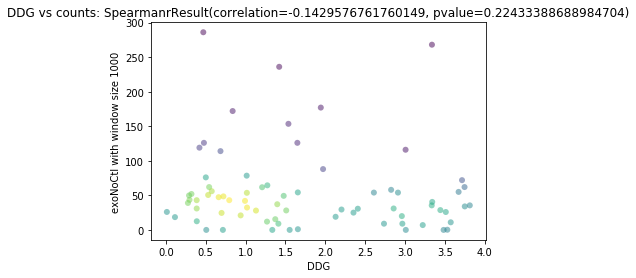

seq_bjr


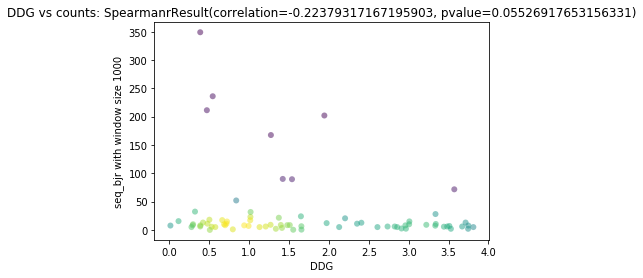

Window Size:  1200
exo


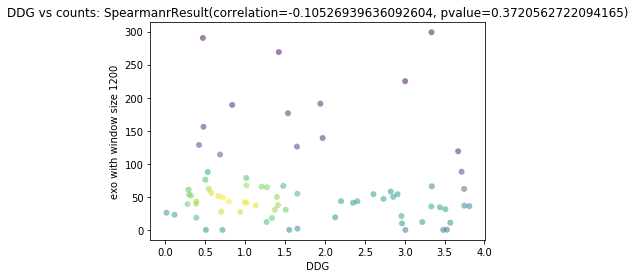

exoNoCtl


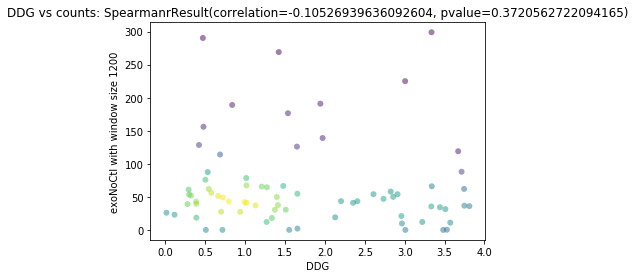

seq_bjr


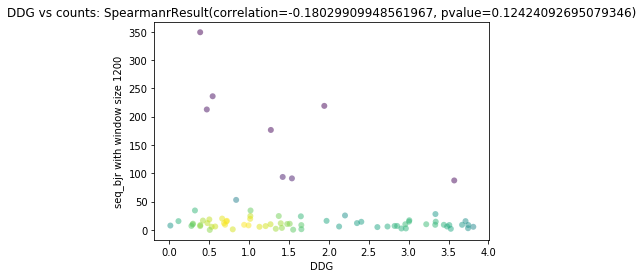

In [15]:
window_sizes = [16, 32, 64, 128, 150, 200, 256, 546, 1000, 1200]
for window in window_sizes:
    print("Window Size: ",window)
    start = int((seq_len/2)-(window/2))
    end = int((seq_len/2)+(window/2))
    for key in tfToBigWigs.keys():
        print(key)
        yvals = []
        for flank in seqToCoord.keys():
            yvals.append(np.sum(posFootprint[key][flank][start:end]+ \
                                negFootprint[key][flank][start:end]))
        xy = np.vstack([xvals,yvals])
        z = gaussian_kde(xy)(xy)
        smallFont = {'size' : 10}
        plt.rc('font', **smallFont)
        fig, ax = plt.subplots()
        ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
        plt.xlabel("DDG")
        plt.ylabel(key+" with window size "+str(window))
        plt.title("DDG vs counts: "+str(spearmanr(xvals, yvals)))
        plt.show()

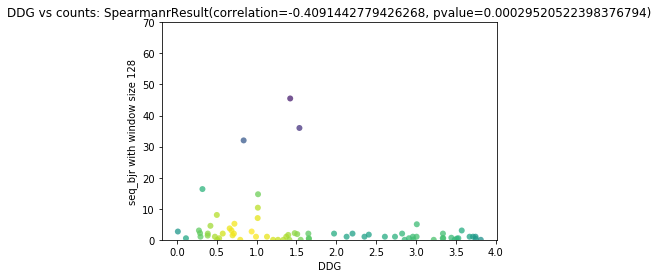

In [16]:
window = 128
start = int((seq_len/2)-(window/2))
end = int((seq_len/2)+(window/2))
key = "seq_bjr"
yvals = []
for flank in seqToCoord.keys():
    yvals.append(np.sum(posFootprint[key][flank][start:end]+ \
                        negFootprint[key][flank][start:end]))
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.75)
plt.xlabel("DDG")
plt.ylabel(key+" with window size "+str(window))
plt.ylim((0,70))
plt.title("DDG vs counts: "+str(spearmanr(xvals, yvals)))
plt.show()

Slope of linear fit:  -0.5114838976603037 , and intercept:  2.5893893941024517


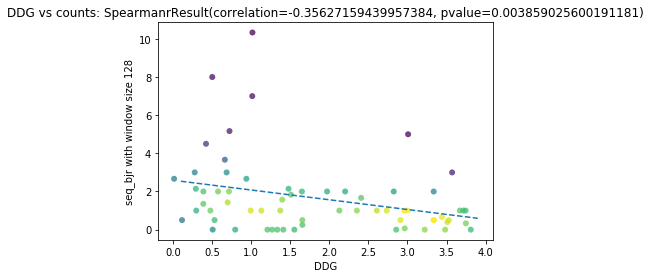

In [20]:
from scipy import stats
start = int((seq_len/2)-(window/2))
end = int((seq_len/2)+(window/2))
yvals = []
xvals = []
for motif in seqToCoord.keys():
    val = np.sum(posFootprint[key][motif][start:end]+ \
                 negFootprint[key][motif][start:end])
    if val > 11: continue
    xvals.append(np.mean(seqToDdg[motif]))
    yvals.append(val)
slope, intercept, r_value, p_value, std_err = stats.linregress(xvals,yvals)
print("Slope of linear fit: ", slope, ", and intercept: ", intercept)
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.75)
inp = np.linspace(0.1, 3.9, num=100)
fit = slope*inp + intercept
ax.plot(inp, fit, '--')
plt.xlabel("DDG")
plt.ylabel(key+" with window size "+str(window))
plt.title("DDG vs counts: "+str(spearmanr(xvals, yvals)))
plt.show()